In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import numpy as np
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2
#

In [4]:
f = open('mjo_data.csv', 'r')
lines = f.readlines()
print(len(lines))

In [7]:
RMM1 = np.zeros(len(lines)-1)
RMM2 = np.zeros(len(lines)-1)
Amplitude = np.zeros(len(lines)-1)
Phase = np.zeros(len(lines)-1)
for i in range(1, len(lines)):
    RMM1[i-1] = np.float64(lines[i].strip().split()[3])
    RMM2[i-1] = np.float64(lines[i].strip().split()[4])
    Phase[i-1] = np.float64(lines[i].strip().split()[5])
    Amplitude[i-1] = np.float64(lines[i].strip().split()[6])

# np.save('RMM1.npy', RMM1)
# np.save('RMM2.npy', RMM2)
# np.save('Amplitude_New.npy', Amplitude)
# np.save('Phase.npy', Phase)


(17701,)
[1385 1386 1387 1388 1389 1390 1391 1392 1393 1394 1395 1396 1397 1398
 1399 1400 1401 1402 1403 1404 1405 1406 1407 1408 1409 1410 1411 1412
 1413 1414 1415 1416 1417 1418 1419 1420 1421 1422 1423 1424 1425 1426
 1427 1428 1429 1430 1431 1432 1433 1434 1435 1436 1437 1438 1439 1440
 1441 1442 1443 1444 1445 1446 1447 1448 1449 1450 1451 1452 1453 1454
 1455 1456 1457 1458 1459 1460 1461 1462 1463 1464 1465 1466 1467 1468
 1469 1470 1471 1472 1473 1474 1475 1476 1477 1478 1479 1480 1481 1482
 1483 1484 1485 1486 1487 1488 1489 1490 1491 1492 1493 1494 1495 1496
 1497 1498 1499 1500 1501 1502 1503 1504 1505 1506 1507 1508 1509 1510
 1511 1512 1513 1514 1515 1516 1517 1518 1519 1520 1521 1522 1523 1524
 1525 1526 1527 1528 1529 1530 1531 1532 1533 1534 1535 1536 1537 1538
 1539 1540 1541 1542 1543 1544 1545 1546 1547 1548 1549 1550 1551 1552
 1553 1554 1555 1556 1557 1558 1559 1560 1561 1562 1563 1564 1565 1566
 1567 1568 1569 1570 1571 1572 1573 1574 1575 1576 1577 1578 1579 15

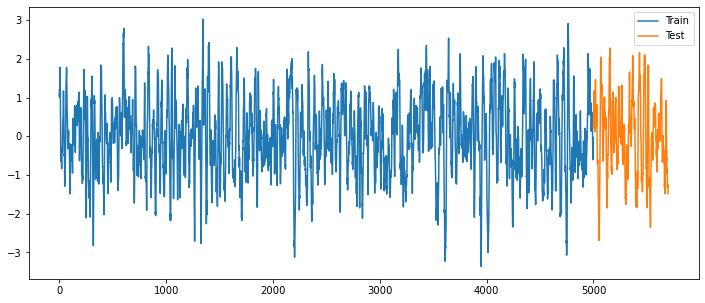

In [8]:
data_RMM1 = {}
data_RMM2 = {}
# entire_data = np.load('amplitude_data.npy')
print(RMM1.shape)
data_RMM1['train'] = RMM1[:10000]
data_RMM1['test'] = RMM1[10000:]
idx1 = np.where(data_RMM1['train'] > 1e34)[0]
print(idx1)

print(RMM2.shape)
data_RMM2['train'] = RMM2[:10000]
data_RMM2['test'] = RMM2[10000:]
idx2 = np.where(data_RMM2['train'] > 1e34)[0]
print(idx2)


data_RMM2['train'] = np.delete(data_RMM2['train'], idx1)
print(data_RMM2['train'].shape, data_RMM2['test'].shape)

N_train = 5000
N_forecast = 700
Ztrain = data_RMM2['train'][:N_train] 
Ztest = data_RMM2['train'][N_train:N_train+N_forecast]
# data['train'] = np.load(f'{datadir}/amplitude_data.npy').T
# data['test'] = np.load(f'{datadir}/Z500_Test_Snapshots.npy').T

plt.figure(figsize=(12, 5))
plt.plot(np.arange(N_train), Ztrain)
plt.plot(np.arange(N_train, N_train+N_forecast), Ztest)
plt.legend(['Train', 'Test'])

In [9]:
def rolling(a, window):
    shape = (a.size - window + 1, window)
    strides = (a.itemsize, a.itemsize)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [10]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
#         self.
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
#         covar_x = gpytorch.kernels.RBFKernel(x) + gpytorch.white_noise_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

/opt/homebrew/Caskroom/miniconda/base/envs/scientific/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.9214725494384766 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/scientific/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.596954107284546 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/opt/homebrew/Caskroom/

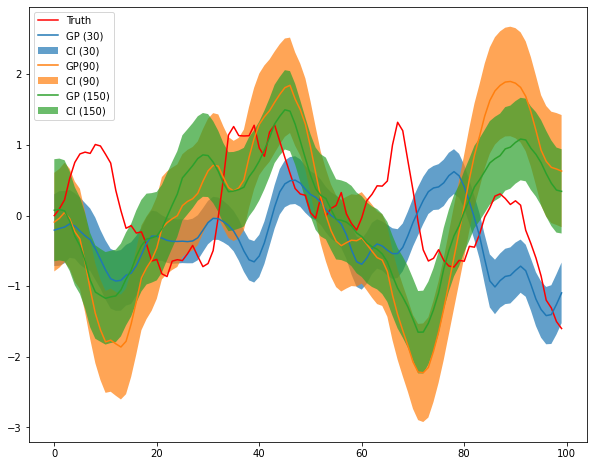

In [11]:
rolling_widths = [30, 90, 150]

plot_colors = ['tab:blue', 'tab:orange', 'tab:green']

#plot_colors = ['tab:blue']

f, ax = plt.subplots(1, 1, figsize=(10, 8))
prediction_window  = 100
fixed_offset = 500
fixed_start = 200
dict_predictions ={}
dict_lower_confidence={}
dict_upper_confidence={}

ax.plot(np.arange(prediction_window),Ztest[fixed_start:fixed_start+prediction_window], 'r')
for rolling_width, col in zip(rolling_widths, plot_colors):
    Input_X = rolling(Ztrain[:-1], rolling_width)
    Output_Y = Ztrain[rolling_width:]
    x_np = torch.from_numpy(Input_X).float()
    y_np = torch.from_numpy(Output_Y).float()
    
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
# gpytorch.likelihoods.FixedNoiseGaussianLikelihood()
    model = ExactGPModel(x_np, y_np, likelihood)
    model = model.to(torch.float)
    
    smoke_test = ('CI' in os.environ)
    training_iter = 2 if smoke_test else 200

# Find optimal model hyperparameter
    model.train()
    likelihood.train()

# Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
# "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    for i in range(training_iter):
       
        
    # Zero gradients from previous iteration
        optimizer.zero_grad()
    # Output from model
        output = model(x_np)
    # Calc loss and backprop gradients
        loss = -1*mll(output, y_np)
        loss.backward()
#         print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#              i + 1, training_iter, loss.item(),
#              model.covar_module.base_kernel.lengthscale.item(),
#             model.likelihood.noise.item() ))
        optimizer.step()
        
        
    
    predictions = np.zeros(prediction_window)
    lower_confidence = np.zeros(prediction_window)
    upper_confidence = np.zeros(prediction_window)
    temp = np.copy(Ztest[:prediction_window+fixed_offset-1])
    temp = rolling(temp, rolling_width)
    model.eval()
    likelihood.eval()
    fixed_start = 200
    for i in range(prediction_window):
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            temp1 = temp[i+fixed_start - rolling_width,:]
            if(i != 0):
                temp1[-1] = observed_pred.mean.numpy()
            test_x = torch.from_numpy(temp1.reshape((1, rolling_width))).float()
            observed_pred = likelihood(model(test_x))
#         print(observed_pred)
            lower, upper = observed_pred.confidence_region()
            predictions[i] = observed_pred.mean.numpy()
            lower_confidence[i] = lower.detach().numpy()
            upper_confidence[i] = upper.detach().numpy()
    
    dict_predictions[rolling_width] = predictions
    dict_lower_confidence[rolling_width] = lower_confidence
    dict_upper_confidence[rolling_width] = upper_confidence
    ax.plot(np.arange(prediction_window), predictions, col)
    ax.fill_between(np.arange(prediction_window), lower_confidence, 
                     upper_confidence, alpha=0.7)
# y_np = torch.from_numpy(Output_Y)
# Input_X = rolling(Ztrain[:-1], rolling_width)
# print(Input_X.shape)
# Output_Y = Ztrain[rolling_width:]
# print(Output_Y.shape)
# x_np = torch.from_numpy(Input_X)
# y_np = torch.from_numpy(Output_Y)
# print(Input_X)
# #Increase rolling_width 
# #Increase number of training points

ax.legend(['Truth','GP (30)', 'CI (30)', 'GP(90)', 'CI (90)', 'GP (150)', 'CI (150)' ])
# ax.legend(['Truth','GP (60)', 'GP(100)', 'GP (150)' ])
# ax.legend(['Truth','GP (30)'])
# ax.set_ylim([-1.0, 1.0])